In [1]:
import sys
sys.path.append('..')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [37]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from fastai.text import *
from src.dataloader import DatasetStream
from src.models import ArCosModel, FullyConnectedNet, nn_evaluate

# Datasets and Dataloaders

Link to download USE embeddings: 
[Train](https://drive.google.com/file/d/1g2izNAlAnszU_PNALYQJWUqHWoBCmfM9/view?usp=sharing)

In [3]:
# Path containing USE embeddings
DATA=Path('../data/universal-sentence-encoder/')

# Config
bs=48
emb_sz = 512

In [4]:
# Because of large memory requirements of the array, we will use memory mapped
# numpy arrays.

qnemb = np.load(str(DATA/'qnemb.npy'), mmap_mode='r').astype(np.float32)
qnlabels = np.load(str(DATA/'qnlabels.npy'), mmap_mode='r').astype(np.int64)

# Get CV idxs
total = qnlabels.shape[0]
idxs = np.array([i for i in range(total)])
trn_idxs, val_idxs = train_test_split(idxs, test_size=0.1, random_state=0)

# Make Datasets
trn_ds = DatasetStream(qnemb, qnlabels, trn_idxs)
val_ds = DatasetStream(qnemb, qnlabels, val_idxs)

# Make Dataloaders
trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=False)

# Create fast.ai Model Data Object
md = ModelData('.', trn_dl, val_dl)

In [5]:
# View a sample
x, y = next(iter(md.trn_dl))
print(x.shape, y.shape)

torch.Size([48, 2, 512]) torch.Size([48])


The middle two dimensions correspond to different embedding for the question pairs.

# Models

### 1. ArCos (Baseline)

Similar to the distance formulation used in the original "Universal Sentence Encoder" paper for judging similarity between pairs of sentences, as baseline we first compute the cosine similarity between vectors of the question pairs and then apply arccos to convert it into an angular distance. We then map the distances to probabilities using a Logistic Regression Classifier.

In [7]:
arcos = ArCosModel(md, class_weight="balanced")
arcos.fit()
arcos.evaluate()

Completed 1 batches
Completed 2001 batches
Completed 4001 batches
Completed 6001 batches
Completed all batches!


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   53.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.5s finished


Completed 1 batches
Completed all batches!
Accuracy:  0.7180489252764105
Negative Log loss:  0.5370306172297293
             precision    recall  f1-score   support

        0.0       0.84      0.68      0.75     25520
        1.0       0.59      0.78      0.67     14909

avg / total       0.75      0.72      0.72     40429



### 2. Feedforward Neural Net

In [14]:
# Convert labels to float datatype for Binary cross entropy loss
md.trn_ds.y = md.trn_ds.y.astype(np.float32)
md.val_ds.y = md.val_ds.y.astype(np.float32)

In [28]:
learn = Learner(md, SingleModel(FullyConnectedNet(emb_sz, [2048, 1024, 512], [0.1, 0.3, 0.1]).cuda()), 
                crit=F.binary_cross_entropy, opt_fn=optim.Adam)

 70%|███████   | 5311/7581 [01:05<00:27, 81.39it/s, loss=1.99]

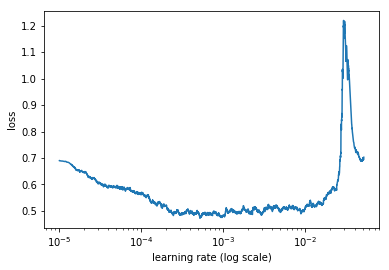

 70%|███████   | 5311/7581 [01:23<00:35, 63.46it/s, loss=1.99]

In [30]:
wd = 1e-7
learn.lr_find(1e-5, 2, wds=wd)
learn.sched.plot()

In [32]:
learn.fit(1e-4, 1, cycle_len=1, wds=wd, use_clr=(10, 10))

  5%|▌         | 410/7581 [00:06<01:48, 66.05it/s, loss=0.613]
epoch      trn_loss   val_loss   
    0      0.381976   0.383019  



[array([0.38302])]

In [33]:
learn.fit(5e-5, 1, cycle_len=5, wds=wd, use_clr=(20, 10))

epoch      trn_loss   val_loss   
    0      0.372424   0.375201  
    1      0.33639    0.360276  
    2      0.334444   0.351054  
    3      0.29783    0.350916  
    4      0.279624   0.350018  



[array([0.35002])]

In [40]:
nn_evaluate(val_dl, learn.model)

Accuracy:  0.8419204036706325
Negative Log loss:  0.3500181688324724
             precision    recall  f1-score   support

        0.0       0.88      0.86      0.87     25520
        1.0       0.77      0.81      0.79     14909

avg / total       0.84      0.84      0.84     40429

